# Step #1 Load the Titanic Data

In [6]:
# A tutorial for this file is available at www.relataly.com

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# set file path
filepath = "data/titanic/"

# Load train and test datasets
titanic_train_df = pd.read_csv(filepath + 'titanic-train.csv')
titanic_test_df = pd.read_csv(filepath + 'titanic-test.csv')
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step #2 Preprocess and Explore the Data

In [7]:
# Define a function for preprocessing the train and test data 
def preprocess(dfx):
    df = dfx.copy()
    
    # Deleting some columns from the data
    new_df = df[df.columns[~df.columns.isin(['Survived', 'Cabin', 'PassengerId', 'Name', 'Ticket'])]].copy()
    
    # Replace missing values
    new_df.fillna(df.mean(), inplace=True)
    new_df['Embarked'].fillna('C', inplace=True)
    
    # Decode categorical values as integer values
    new_df_b = new_df.copy()
    new_df_b['Sex'] = np.where(new_df_b['Sex']=='male', 0, 1) 
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='S', '1', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='Q', '2', inplace=True)
    new_df_b['Embarked'].mask(new_df_b['Embarked']=='C', '3', inplace=True)
    
    return new_df_b

# Create the training dataset train_df & the label dataset
x_df = preprocess(titanic_train_df).copy()
y_df = titanic_train_df['Survived'].copy()
x_df.head()

<ipython-input-7-865d7408f48e>:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  new_df.fillna(df.mean(), inplace=True)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,3
2,3,1,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,3,0,35.0,0,0,8.0500,1


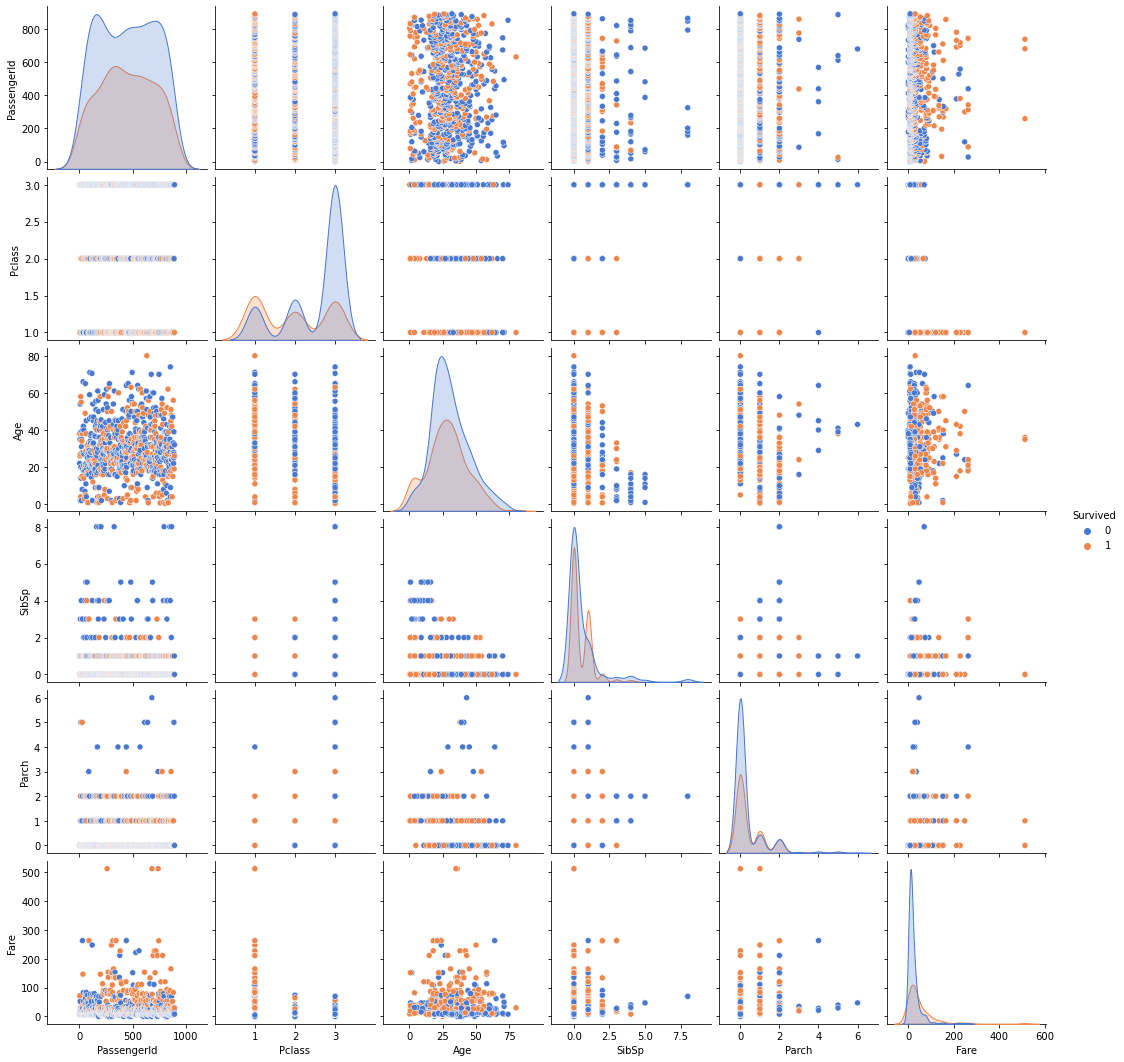

In [30]:
# # Create histograms for feature columns separated by prediction label value
df_plot = titanic_train_df.copy()

# class_columnname = 'Churn'
sns.pairplot(df_plot, hue="Survived", height=2.5, palette='muted')

# Step #3 Split the Data into Train and Test

In [14]:
# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

# Step #4 Train a single Random Forest Classification Model

([<matplotlib.axis.YTick at 0x173a60118b0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

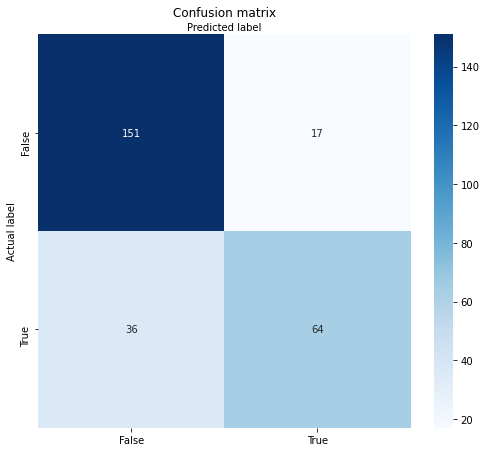

In [25]:
# Train a single random forest classifier - parameters are a best guess
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.xlabel('Predicted label') 
plt.ylabel('Actual label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

# Step #5 Hyper-parameter-tuning Using Grid Search

In [27]:
# Define parameters
max_depth=[2, 8, 16]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the gridsearch
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.79131613 0.77686452 0.78969032 0.82188387 0.82348387 0.82190968
 0.77858065 0.78978065 0.78014194], using {'max_depth': 8, 'n_estimators': 128}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.057053,0.001688,0.005412,0.000435,2,64,"{'max_depth': 2, 'n_estimators': 64}",0.800,0.792,0.792,0.798387,0.774194,0.791316,0.009160,4
1,0.109068,0.001933,0.008517,0.000452,2,128,"{'max_depth': 2, 'n_estimators': 128}",0.768,0.792,0.784,0.774194,0.766129,0.776865,0.009808,9
2,0.214284,0.002746,0.015713,0.000397,2,256,"{'max_depth': 2, 'n_estimators': 256}",0.784,0.824,0.784,0.766129,0.790323,0.789690,0.018960,6
3,0.060801,0.000750,0.005800,0.000400,8,64,"{'max_depth': 8, 'n_estimators': 64}",0.800,0.840,0.792,0.814516,0.862903,0.821884,0.026218,3
4,0.128833,0.007920,0.010329,0.000748,8,128,"{'max_depth': 8, 'n_estimators': 128}",0.792,0.832,0.816,0.806452,0.870968,0.823484,0.027072,1
5,0.245333,0.008381,0.017582,0.000611,8,256,"{'max_depth': 8, 'n_estimators': 256}",0.792,0.824,0.800,0.814516,0.879032,0.821910,0.030648,2
6,0.065422,0.001694,0.005400,0.000489,16,64,"{'max_depth': 16, 'n_estimators': 64}",0.736,0.800,0.744,0.774194,0.838710,0.778581,0.037689,8
7,0.131963,0.003336,0.010603,0.001743,16,128,"{'max_depth': 16, 'n_estimators': 128}",0.752,0.816,0.768,0.766129,0.846774,0.789781,0.035768,5
8,0.256239,0.004942,0.018017,0.000563,16,256,"{'max_depth': 16, 'n_estimators': 256}",0.752,0.792,0.768,0.741935,0.846774,0.780142,0.037362,7


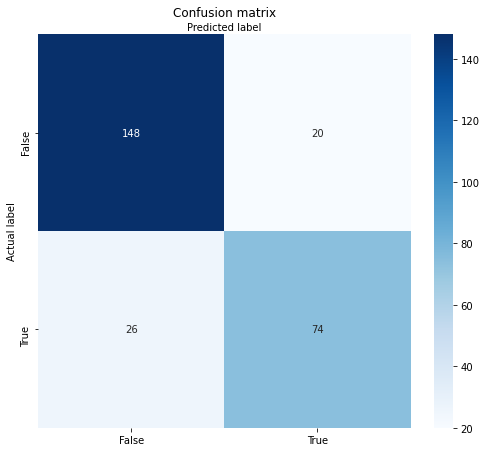

In [32]:
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
tick_marks = [0.5, 1.5]